# LIGHTGBM BINARY
https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

Control Params | Core Params | Metric Params | IO Params
-------------- | ----------- | ------------- | ---------
max_depth | task | metric (mae, mse, binary_logloss, multi_logloss) | max_bin
min_data_in_leaf | application (regression, binary, multiclass)| categorical_feature
feature_fraction | boosting (gbdt, rf, dark, goss) | ignore_column
bagging_fraction | num_boost_round | save_binary
early_stopping_round | learning_rate
lambda | num_leaves
min_gain_to_split | device (GPU or CPU)
max_cat_group | 

In [1]:
%load_ext chime
%matplotlib inline

import os
import sys
import logging
from glob import glob
import pickle
import chime
import sqlite3

from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, classification_report
from skimage.exposure import adjust_sigmoid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import rasterio as rio
from rasterio.windows import from_bounds

import pandas as pd
import geopandas as gpd
import numpy as np

from datetime import datetime
import json

import matplotlib.pyplot as plt
import lightgbm as lgb

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from utils import *

import optuna.integration.lightgbm as olgb

import swifter
from shapely.geometry import Point
from Functions import getSentinelBandFile


In [2]:
"""
def calcMeanDiffs(df, headers):
    #
    #Given a dataframe containing columns of RED, GREEN, BLUE, and NIR, calculate their difference from the mean of the others. Add these new columns to the headers to be used
    #
    df["REDness"] = df.apply(lambda r: calcMeanDiff(r, "RED"), axis=1)
    df["GREENness"] = df.apply(lambda r: calcMeanDiff(r, "GREEN"), axis=1)
    df["BLUEness"] = df.apply(lambda r: calcMeanDiff(r, "BLUE"), axis=1)
    df["NIRness"] = df.apply(lambda r: calcMeanDiff(r, "NIR"), axis=1)
    df["RGBNmean"] = np.nanmean([df["RED"], df["GREEN"], df["BLUE"], df["NIR"]], axis=0)

    if "REDness" not in headers:
        headers += ["REDness", "GREENness", "BLUEness", "NIRness", "BaseMean"]
    return df, headers
"""

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return np.mean(errors), accuracy


def buildModel(params, dataset, features, classCol, fullReport=False, writeOut=False):
    """ Given parameters, a pandas dataframe, a list of feature column names, and the name of the class column"""
    X = dataset[features]
    y = dataset[classCol]
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.25, random_state=7)
    train_data = lgb.Dataset(X_train, label=Y_train)
    valid_data = lgb.Dataset(X_valid, label=Y_valid, reference=train_data)
    gbmModel = lgb.LGBMClassifier(**params, metric="custom")
    
    gbmModel.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), eval_metric=evalF1, early_stopping_rounds=50)#, verbose_eval=False)
    
    preds = gbmModel.predict(X_valid)

    scores = {}
    f1 = f1_score(Y_valid, preds, average='weighted')

    scores["F1"] = f1
    
    if fullReport:
        accuracy = accuracy_score(Y_valid, preds)
        kappa = cohen_kappa_score(Y_valid, preds)
        print(f"Model:\n\tAccuracy: {accuracy}\n\tF1: {f1}\n\tCohensKappa: {kappa}")
        print(classification_report(Y_valid, preds, target_names=[k for k,v in values_2019_lookup.items()][:-2]))#
        plotConfusionMatrix(gbmModel, X_valid, Y_valid)
    if writeOut:
        day = datetime.strftime(datetime.now(), "%Y%m%d")
        model_name = f"lightGBM_{day}.sav"
        model_path = os.path.join(os.path.abspath("./Models"), model_name)
        pickle.dump(gbmModel, open(model_path, "wb"))
        params_path = f"./Models/LGBMClassifierParams_{day}.txt"
        with open(params_path, "w+") as txt:
            txt.write(json.dumps(params))
        print(f"Wrote out trained model to \n\t{model_path} and paramameters to \n\t{params_path}")
    
    return gbmModel, scores


def optunaObjective(trial):
    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "multi_logloss")
    
    search_params = {
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.5),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 0.5),
        "num_leaves": trial.suggest_int("num_leaves", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 10, 100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
        "num_boost_round": trial.suggest_int("num_boost_round", 25, 400), # change min limit to 25 because best fits were hitting limit of 50 
        "boosting_type": trial.suggest_categorical('boosting_type', ["rf", "gbdt"]), # used dart on previous searches. not best for this
        "n_estimators": trial.suggest_int("n_estimators", 100, 500)
    }
    
    params = {**fixed_params, **search_params}
    scores = []
    for data in subGroups:
        #data = subGroups[i]
        gbm, modelScores = buildModel(params, data, featureHeaders, class_col)
                
        #preds = gbm.predict(X_valid)
        #accuracy = accuracy_score(y_valid, preds)
        #f1 = f1_score(y_valid, preds, average='weighted')
        scores.append(modelScores["F1"])
        
    meanScore = np.mean(scores)
    
    return meanScore


def evaluate_macroF1_lgb(truth, predictions):  
    #pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='weighted')
    return ('macroF1', f1, True) 


def plotConfusionMatrix(model, xValid, yValid):
    labels, counts = np.unique(yValid, return_counts=True)
    pred_lgb = model.predict(xValid)
    cm = confusion_matrix(yValid, pred_lgb, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)


    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=[k for i in labels for k,v in values_2019_lookup.items() if i == v],
           yticklabels=[k for i in labels for k,v in values_2019_lookup.items() if i == v],
           title='Normalized Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.4f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


def evalF1(y_true, y_pred):
    #https://stackoverflow.com/questions/57222667/light-gbm-early-stopping-does-not-work-for-custom-metric
    # returns (eval_name, eval_result, is_higher_better
    y_pred = y_pred.reshape(len(np.unique(y_true)),-1).argmax(axis=0)
    return 'F1', f1_score(y_true, y_pred, average='weighted'), True


def getCorrelation(df, cortype, threshold=0.1):
    """ Identifies absolute (negative or positive) correlation (cortype) of columns in DF
    and returns all over threshold (threshold) except "LCClassInt """
    cor = df.corr(method=cortype)
    #display(cor[cor.index == "LCClassInt"])
    cor_target = abs(cor["LCClassInt"])
    relevant_features = cor_target[cor_target>threshold]
    #print(f"{len(relevant_features)} features identified over threshold {threshold} using {cortype}")
    relevant_features.sort_values(ascending=False, inplace=True)
    relevant_features.drop(index="LCClassInt", inplace=True)
    
    return relevant_features


def getRelevantFeatures(df, threshold):
    corFeatures = {}
    for cor_type in ('pearson', 'spearman'):
        goodFeatures = getCorrelation(df, cor_type, threshold)
        corFeatures[cor_type] = goodFeatures

    coeff_df = pd.DataFrame.from_dict(corFeatures)
    #coeff_df["PearsonAndSpearman"] = coeff_df.apply(lambda r: pd.notnull(r.pearson) and pd.notnull(r.spearman),axis=1)
    #coeff_df["PearsonOrSpearman"] = coeff_df.apply(lambda r: pd.notnull(r.pearson) or pd.notnull(r.spearman),axis=1)

    spearAndPear = coeff_df[(coeff_df.pearson>threshold) | (coeff_df.spearman>threshold)]
    strongFeatures = spearAndPear.index.tolist()
    print(f"Identified {len(strongFeatures)} features (using Pearson and Spearman) to use in model")
    
    return spearAndPear.index.tolist()


def getOptimumParam(lgbm_study, minimize=True):
    history = lgbm_study.trials_dataframe()
    history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
    # limit trials to those within 1.2x of the best score (assuming lower scores are better)
    best_score = lgbm_study.best_trial.value
    if minimize:
        best_performers = history[(history.value<(best_score*1.2))]# & (history.DurationSeconds < seconds_limit)]
    else:
        best_performers = history[(history.value>(best_score*0.95))]# & (history.DurationSeconds < seconds_limit)]
        
    optimum_trial = best_performers[best_performers.DurationSeconds == best_performers.DurationSeconds.min()] 
    optimum_trial_number = optimum_trial.number.values[0]
    optimum_params = lgbm_study.get_trials()[optimum_trial_number].params
    print(f"optimum_params: {optimum_params}")
    
    return optimum_params


def setOptimumParams(lgbmTuner, minimize):
    for k,v in getOptimumParam(lgbmTuner.study, minimize).items():
        lgbmTuner.lgbm_params[k] = v
    return lgbmTuner


def useOptunaLGBMTuner(trainDataset, validDataset, params, lc_class, suffix, resume=False):
    """ Uses optunas build in tuner for Light GBM.  A bit faster"""
    # Add stream handler of stdout to show the messages
    optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
    storage_name = f"OptunaTuner_Binary_{suffix}"
    
    study_loc = f"Models/{storage_name}.db"
    storage_loc = f"sqlite:///{study_loc}"
    studyName = f"lightgbm_tuner_{lc_class}_{tday}"
    
    if not resume and os.path.exists(study_loc):
        os.remove(study_loc)
    
    tunerStudy = optuna.create_study(study_name=studyName, direction="minimize", storage=storage_loc, load_if_exists=resume)
    
    tuner = olgb.LightGBMTuner(
            params, train_set=trainDataset, valid_sets=[trainDataset, validDataset], verbose_eval=100,
            optuna_callbacks=[mlflow_callback], study=tunerStudy
        )
    
    print("\nTuning Number of Leaves")
    tuner.tune_num_leaves(n_trials=20)
    #tuner = setOptimumParams(tuner, minimize=True)
    print("\nTuning feature fraction (1)")
    tuner.tune_feature_fraction(n_trials=20)
    #tuner = setOptimumParams(tuner, minimize=True)
    print("\nTuning Bagging")
    tuner.tune_bagging(n_trials=10)
    #tuner = setOptimumParams(tuner, minimize=True)
    print("\nTuning feature fraction (2)")
    tuner.tune_feature_fraction_stage2(n_trials=6)
    #tuner = setOptimumParams(tuner, minimize=True)
    print("\nTuning Lambdal1 and l2")
    tuner.tune_regularization_factors(n_trials=20)
    #tuner = setOptimumParams(tuner, minimize=True)
    #print("\nTuning Min Data in Leaf")
    #tuner.tune_min_data_in_leaf()
    #tuner = setOptimumParams(tuner, minimize=True)
    
    return tuner

    newModel = lgb.train(tuner.best_params, train_set=trainDataset, valid_sets=[trainDataset, validDataset], verbose_eval=1)
    model_name = f"lightGBMBinary{lc_class}_LGBMTuner_{suffix}.sav"
    model_path = os.path.join(os.path.abspath("../notebooks/Models"), model_name)
    pickle.dump(newModel, open(model_path, "wb"))
    print(f"Wrote out model to {model_path}")
    
    tunerPrediction = np.rint(newModel.predict(X_valid, num_iteration=newModel.best_iteration))
    tunerPrediction = [np.argmax(x) for x in tunerPrediction]
    
    accuracy = accuracy_score(Y_valid, tunerPrediction)
    print(f"Accuracy: {accuracy}")
    print(tuner.best_params)
    
    
    return tunerStudy

In [3]:
trainingSamples_locs = {'PondLake': '../OtherData/TrainingData/PondLake_20210519.pickle',
                        'Pool': '../OtherData/TrainingData/Pool_20210519.pickle',
                        'DenseVeg': '../OtherData/TrainingData/DenseVeg_20210519.pickle',
                        'IrrigatedLand': '../OtherData/TrainingData/IrrigatedLand_20210519.pickle',
                        'Asphault': '../OtherData/TrainingData/Asphault_20210519.pickle',
                        'Impervious': '../OtherData/TrainingData/Impervious_20210519.pickle',
                        'Structure': '../OtherData/TrainingData/Structure_20210519.pickle',
                        'Barren': '../OtherData/TrainingData/Barren_20210519.pickle',
                        'SparseVeg': '../OtherData/TrainingData/SparseVeg_20210519.pickle',
                        'ParkingLot': '../OtherData/TrainingData/ParkingLot_20210519.pickle',
                        'Sidewalk': '../OtherData/TrainingData/Sidewalk_20210519.pickle',
                        'BarrenUrban': '../OtherData/TrainingData/BarrenUrban_20210825.pickle'
                       }

values_2019_lookup = {'PondLake': 1, 'Pool': 2, 'Barren': 3, 'SparseVeg': 4, 'DenseVeg': 5,
                      'IrrigatedLand': 6, 'Asphault': 7, 'Impervious': 8, 'Structure': 9,
                      "ParkingLot": 7, "Sidewalk": 8, "BarrenUrban": 3}

for lcclass, fileloc in trainingSamples_locs.items():
    trainingSamples_locs[lcclass] = fileloc.replace("20210519", "20210825")
trainingSamples_locs

trainingSamples_locs

{'PondLake': '../OtherData/TrainingData/PondLake_20210825.pickle',
 'Pool': '../OtherData/TrainingData/Pool_20210825.pickle',
 'DenseVeg': '../OtherData/TrainingData/DenseVeg_20210825.pickle',
 'IrrigatedLand': '../OtherData/TrainingData/IrrigatedLand_20210825.pickle',
 'Asphault': '../OtherData/TrainingData/Asphault_20210825.pickle',
 'Impervious': '../OtherData/TrainingData/Impervious_20210825.pickle',
 'Structure': '../OtherData/TrainingData/Structure_20210825.pickle',
 'Barren': '../OtherData/TrainingData/Barren_20210825.pickle',
 'SparseVeg': '../OtherData/TrainingData/SparseVeg_20210825.pickle',
 'ParkingLot': '../OtherData/TrainingData/ParkingLot_20210825.pickle',
 'Sidewalk': '../OtherData/TrainingData/Sidewalk_20210825.pickle',
 'BarrenUrban': '../OtherData/TrainingData/BarrenUrban_20210825.pickle'}

In [4]:
class_col = "LCClassInt"

trainingSamples = []
for lcClass, file in trainingSamples_locs.items():
    df = pd.read_pickle(file)
    if lcClass == "Structure":
        df = df[df.HAG >= 6]
        
    if lcClass == "PondLake" or lcClass == "Pool" or lcClass == "IrrigatedLand" or lcClass == "Impervious" or "Barren" in lcClass or lcClass == "Asphault":
        df = df[df.HAG == 0] 
        
    if lcClass == "PondLake":
        #df = df[df.MSAVI < (120/255)*np.iinfo(np.uint16).max]
        #df = df[df.NDVI < (15/255)*np.iinfo(np.uint16).max]
        df = df[df.MSAVI < (128/255)*np.iinfo(np.uint16).max]
        df = df[df.NDVI < (132/255)*np.iinfo(np.uint16).max]
        
    if lcClass == "Pool":
        #df = df[df.MSAVI < (100/255)*np.iinfo(np.uint16).max]
        #df = df[df.NDVI < (65/255)*np.iinfo(np.uint16).max]
        df = df[df.MSAVI < (128/255)*np.iinfo(np.uint16).max]
        df = df[df.NDVI < (132/255)*np.iinfo(np.uint16).max]
            
    if lcClass == "Asphault" or lcClass == "ParkingLot":
        df.loc[df.NIR >= (100/255)*np.iinfo(np.uint16).max, "LCClass"] = "Impervious"
    
    print(lcClass, len(df))
        
    trainingSamples.append(df)
    
trainingSamples = pd.concat(trainingSamples).reset_index(drop=True)
trainingSamples = trainingSamples[~(trainingSamples.RED == 0) & ~(trainingSamples.GREEN == 0) & ~(trainingSamples.BLUE == 0) & ~(trainingSamples.NIR == 0)]

print(f"{len(trainingSamples)} total samples")

trainingSamples[class_col] = trainingSamples['LCClass'].apply(lambda lcc: values_2019_lookup[lcc])

PondLake 3454380
Pool 4437801
DenseVeg 4141512
IrrigatedLand 4649042
Asphault 4805230
Impervious 4972560
Structure 4751827
Barren 4704748
SparseVeg 5159379
ParkingLot 2527684
Sidewalk 1053586
BarrenUrban 3987757
48645006 total samples


In [5]:
sindicies = ["NDWI", "BSI", "NDVI", "NDVIa", "DBSI", "NDMI"]
sbands = [2, 3, 4, 5, 6, 7, 8, "8A", 11, 12]

sentinel_bands, sentinel_indicies = {}, {}
for b in sbands:
    band = f"B0{b}" if len(str(b)) == 1 else f"B{b}"
    sentinel_bands[band] = getSentinelBandFile(band, "../Sentinel2Data")
for index in sindicies:
    sentinel_indicies[index] = getSentinelBandFile(index, "../Sentinel2Data")
sentinel_bands, sentinel_indicies

({'B02': '../Sentinel2Data\\B02Mean_20190601to20190901_2868.tif',
  'B03': '../Sentinel2Data\\B03Mean_20190601to20190901_2868.tif',
  'B04': '../Sentinel2Data\\B04Mean_20190601to20190901_2868.tif',
  'B05': '../Sentinel2Data\\B05Mean_20190601to20190901_2868.tif',
  'B06': '../Sentinel2Data\\B06Mean_20190601to20190901_2868.tif',
  'B07': '../Sentinel2Data\\B07Mean_20190601to20190901_2868.tif',
  'B08': '../Sentinel2Data\\B08Mean_20190601to20190901_2868.tif',
  'B8A': '../Sentinel2Data\\B8AMean_20190601to20190901_2868.tif',
  'B11': '../Sentinel2Data\\B11Mean_20190601to20190901_2868.tif',
  'B12': '../Sentinel2Data\\B12Mean_20190601to20190901_2868.tif'},
 {'NDWI': '../Sentinel2Data\\NDWI_Sentinel2_20190601to20190901.tif',
  'BSI': '../Sentinel2Data\\BSI_Sentinel2_20190601to20190901.tif',
  'NDVI': '../Sentinel2Data\\NDVIa_Sentinel2_20190601to20190901.tif',
  'NDVIa': '../Sentinel2Data\\NDVIa_Sentinel2_20190601to20190901.tif',
  'DBSI': '../Sentinel2Data\\DBSI_Sentinel2_20190601to20190901

In [6]:
%%time

trainingFeaturesToUse = trainingSamples.columns.tolist()
trainingFeaturesToUse.remove("LCClass")
trainingFeaturesToUse.remove("LCClassInt")

subGroups = []
sampleSize = 20000
overwrite = False
#sampleSize = min(10**6, trainingSamples.LCClassInt.value_counts().min()) # large sample size did not improve classification
subSampleFile_template = f"../OtherData/TrainingData/SubSampleGroup%s_{sampleSize}.pickle"
sentinel_prefix = "Sentinel2_"

for i in range(5):
    start = datetime.now()
    subSampleFile = subSampleFile_template % i
    if not os.path.exists(subSampleFile) or overwrite:
        trainingSamples_sub = getSubSample(data=trainingSamples, maxSampSize=sampleSize, features_cols=trainingFeaturesToUse[:], class_column=class_col)
        trainingSamples_sub["RGBNmean"] = trainingSamples_sub.swifter.apply(lambda r: np.nanmean([r.RED, r.GREEN, r.BLUE, r.NIR]), axis=1)
        trainingSamples_sub["geometry"] = trainingSamples_sub.swifter.apply(lambda r: Point(r.X, r.Y), axis=1)
        for files_dict in [sentinel_bands, sentinel_indicies]:
            for name, file in files_dict.items():
                column_name = f"{sentinel_prefix}{name}"
                print(f"Working {column_name}")
                with rio.open(file) as src:
                    trainingSamples_sub[column_name] = trainingSamples_sub["geometry"].swifter.apply(lambda g: [g[0] for g in src.sample([(g.x, g.y)], 1)][0])
                    
        del trainingSamples_sub["X"], trainingSamples_sub["Y"], trainingSamples_sub["geometry"]
        trainingSamples_sub.to_pickle(subSampleFile)
    else:
        trainingSamples_sub = pd.read_pickle(subSampleFile)

    subGroups.append(trainingSamples_sub)
    print(f"Done {i} - {datetime.now()-start}")


%chime
trainingFeaturesToUse = subGroups[0].columns.tolist()
trainingFeaturesToUse.remove("LCClassInt")
featureHeaders = trainingFeaturesToUse[:]
featureHeaders

Done 0 - 0:00:00.198782
Done 1 - 0:00:00.173529
Done 2 - 0:00:00.211272
Done 3 - 0:00:00.211606
Done 4 - 0:00:00.175812
Wall time: 974 ms


['RED',
 'GREEN',
 'BLUE',
 'NIR',
 'MSAVI',
 'NDVI',
 'NDPI',
 'REDness',
 'GREENness',
 'BLUEness',
 'NIRness',
 'HAG',
 'DPR',
 'GaussianSigma2_RED',
 'GaussianSigma2_GREEN',
 'GaussianSigma2_BLUE',
 'GaussianSigma2_NIR',
 'GaussianSigma5_RED',
 'GaussianSigma5_GREEN',
 'GaussianSigma5_BLUE',
 'GaussianSigma5_NIR',
 'Segment_area',
 'Segment_extent',
 'Segment_eccentricity',
 'Segment_perimeter',
 'RED_LHE',
 'GREEN_LHE',
 'BLUE_LHE',
 'NIR_LHE',
 'RGBNmean',
 'Sentinel2_B02',
 'Sentinel2_B03',
 'Sentinel2_B04',
 'Sentinel2_B05',
 'Sentinel2_B06',
 'Sentinel2_B07',
 'Sentinel2_B08',
 'Sentinel2_B8A',
 'Sentinel2_B11',
 'Sentinel2_B12',
 'Sentinel2_NDWI',
 'Sentinel2_BSI',
 'Sentinel2_NDVI',
 'Sentinel2_NDVIa',
 'Sentinel2_DBSI',
 'Sentinel2_NDMI']

In [7]:
local_class_weight_dict = {'PondLake': 0.02, # dropped to 0.01 from 0.02 on 2021-10-28
                           'Pool': 0.025, # dropped to 0.025 from 0.1 on 2021-10-28
                           'Barren': 42, # raising to  40 from 24 on 2021-06-14, and again to 35 from 29 on 2021-08-28
                           'SparseVeg': 25, # rasing to 20 from 18 on 2021-08-28
                           'DenseVeg': 10.47, # dropping to 10 from 15 on 2021-08-28
                           'IrrigatedLand': 0.5, # dropping to 0.5 from 3 on 2021-08-28
                           'Asphault': 11, 
                           'Impervious': 3, # dropping to 3 from 14 on 2021-06-14, and again to 5 from 9 on 2021-08-28
                           'Structure': 8} # dropping to 8 from 14.88 on 2021-08-28

# replace human readable names with numerical associations
#local_class_weight_dict = { values_2019_lookup[k]: v/100 for k, v in local_class_weight_dict.items() }

print(f"Sum of weights: {np.sum([v for v in local_class_weight_dict.values()])}")

Sum of weights: 100.015


In [8]:
local_class_weight_dict = {'PondLake': 0.02, # dropped to 0.01 from 0.02 on 2021-10-28
                           'Pool': 0.01, # dropped to 0.025 from 0.1 on 2021-10-28
                           'Barren': 26, # raising to  40 from 24 on 2021-06-14, and again to 35 from 29 on 2021-08-28
                           'SparseVeg': 24.47, # rasing to 20 from 18 on 2021-08-28
                           'DenseVeg': 15, # dropping to 10 from 15 on 2021-08-28
                           'IrrigatedLand': 2.5, # dropping to 0.5 from 3 on 2021-08-28
                           'Asphault': 15, 
                           'Impervious': 7, # dropping to 3 from 14 on 2021-06-14, and again to 5 from 9 on 2021-08-28
                           'Structure': 10} # dropping to 8 from 14.88 on 2021-08-28
print(f"Sum of weights: {np.sum([v for v in local_class_weight_dict.values()])}")

Sum of weights: 100.0


In [10]:
#trainingSamples_sub[(trainingSamples_sub.LCClassInt == 8)]

In [8]:
def normalizeNess(df):
    #for b in ["RED", "GREEN", "BLUE", "NIR"]:
    df.reset_index(drop=True, inplace=True)
    df["REDnessNorm"]   = df.swifter.apply(lambda r: ( (r.RED - np.nanmean([r.GREEN, r.BLUE, r.NIR])) / (r.RED + np.nanmean([r.GREEN, r.BLUE, r.NIR])) ), axis=1)
    df["GREENnessNorm"] = df.swifter.apply(lambda r: ( (r.GREEN - np.nanmean([r.RED, r.BLUE, r.NIR])) / (r.GREEN + np.nanmean([r.RED, r.BLUE, r.NIR])) ), axis=1)
    df["BLUEnessNorm"]  = df.swifter.apply(lambda r: ( (r.BLUE - np.nanmean([r.GREEN, r.RED, r.NIR])) / (r.BLUE + np.nanmean([r.GREEN, r.RED, r.NIR])) ), axis=1)
    df["NIRnessNorm"]   = df.swifter.apply(lambda r: ( (r.NIR - np.nanmean([r.GREEN, r.BLUE, r.RED])) / (r.NIR + np.nanmean([r.GREEN, r.BLUE, r.RED])) ), axis=1)
    
    return df

In [9]:
import mlflow
import optuna
import optuna.integration.lightgbm as olgb


def mlflow_callback(study, trial):
    trial_value = trial.value if trial.value is not None else float("nan")

    trial_runtime = float("nan")
    if trial.datetime_start and trial.datetime_complete:
        trial_runtime = (trial.datetime_complete - trial.datetime_start).total_seconds()
    
    with mlflow.start_run(run_name=study.study_name):
        mlflow.log_params(trial.params)
        #mlflow.log_params({"step_name": trial.user_attrs["lightgbm_tuner:step_number"]})
        
        mlflow.log_metrics({
            "trial_number": trial.number,
            "elapsed_time": trial_runtime,
            "mean_squared_error": trial_value,
        })
                          
#sampleSize = 500000
#trainingFeaturesToUse = trainingSamples.columns.tolist()
#trainingFeaturesToUse.remove("LCClass")
#trainingFeaturesToUse.remove("LCClassInt")
#trainingFeaturesToUse.remove("X")
#trainingFeaturesToUse.remove("Y")
#trainingSamples_sub = getSubSample(data=trainingSamples, maxSampSize=sampleSize, features_cols=trainingFeaturesToUse[:], class_column=class_col)
#trainingSamples_sub["RGBNmean"] = np.nanmean([trainingSamples_sub["RED"], trainingSamples_sub["GREEN"], trainingSamples_sub["BLUE"], trainingSamples_sub["NIR"]], axis=0)
#trainingFeaturesToUse.append("RGBNmean")

# Segment area was shown to be high-leverage and inaccurate for binary classification of asphault (2021-06-16)

trainingSamples_sub = pd.concat(subGroups)
print("Creating Normalized Ness Data Column")
trainingSamples_sub = normalizeNess(trainingSamples_sub)
trainingFeaturesToUse = trainingSamples_sub.columns.tolist()
trainingFeaturesToUse.remove("LCClassInt")

sampleSize = len(trainingSamples_sub)/9

values_2019_lookup = {"PondLake": 1,
                      "Pool": 2,
                      "Barren": 3,
                      "SparseVeg": 4,
                      "DenseVeg": 5,
                      "IrrigatedLand": 6,
                      "Asphault": 7,
                      "Impervious": 8,
                      "Structure": 9}


#print("Training Features:\n", trainingFeaturesToUse)
allGoodFeatures = {}
studies = {}
tday = datetime.now().strftime("%Y%m%d")

for k,v in values_2019_lookup.items():
    start = datetime.now()
    if k != "Barren":
        continue
    print(f"\n\nStarting {k}")
    
    classTrainingFeaturesToUse = trainingFeaturesToUse[:]
    if k == "Asphault":
        classTrainingFeaturesToUse.remove("Segment_area") 
        #classTrainingFeaturesToUse.remove("HAG")  ## testing this
    elif k == "Structure":
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "GaussianSigma5_" not in feat]
    elif k == "PondLake":
        #classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "Segment_" not in feat]
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "Sentinel2_" not in feat]
    elif k == "Pool":
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "GaussianSigma" not in feat and "Sentinel2_" not in feat]
    elif k == "DenseVeg" or k == "SparseVeg" or k=="Impervious":
        classTrainingFeaturesToUse = [feat for feat in classTrainingFeaturesToUse if "GaussianSigma_5" not in feat and "Sentinel2_" not in feat]
    
    start = datetime.now()

    print(f"Starting training of binary model for {k}")
    dataset = trainingSamples_sub.copy()
    dataset.dropna(inplace=True)
    # separate all training into binary structure and not
    dataset[class_col] = dataset[class_col].apply(lambda cc: 1 if cc == v else 0)
    
    strongFeatures = getRelevantFeatures(dataset[classTrainingFeaturesToUse + [class_col]], threshold=0.01)
    print(f"Using features\n\t{', '.join(strongFeatures)}")
    allGoodFeatures[k] = strongFeatures
    
    scale_pos_weight = local_class_weight_dict[k] / (100-local_class_weight_dict[k])
    
    X = dataset[strongFeatures]
    y = dataset[class_col]
    
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.25, random_state=7)

    dtrain = lgb.Dataset(X_train, label=Y_train)
    dval = lgb.Dataset(X_valid, label=Y_valid)
    break
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        #"bagging_fraction": 0.7, # tune_bagging tunes bagging_fraction and frequency (2021-11-29)
        "min_child_samples": 20,  #int(0.005*sampleSize),
        "early_stopping_round": 200,
        "n_jobs": 8,
        "scale_pos_weight": scale_pos_weight,
        "num_iterations": 100,  # added on 2021-11-29
        
    }
    
    #study = useOptunaOptunaObjective(dtrain, dval, k)
    study = useOptunaLGBMTuner(dtrain, dval, params=params, lc_class=k, suffix=tday, resume=False)
    
    studies[k]=study
    print(f"CREATED BINARY MODEL FOR LC Class {k}\nTook: {datetime.now()-start}\n\n\n")

    
chime.theme("zelda")
chime.success()

Creating Normalized Ness Data Column





Starting Barren
Starting training of binary model for Barren
Identified 50 features (using Pearson and Spearman) to use in model
Using features
	BLUE, BLUE_LHE, BLUEness, BLUEnessNorm, DPR, GREEN, GREEN_LHE, GREENness, GREENnessNorm, GaussianSigma2_BLUE, GaussianSigma2_GREEN, GaussianSigma2_NIR, GaussianSigma2_RED, GaussianSigma5_BLUE, GaussianSigma5_GREEN, GaussianSigma5_NIR, GaussianSigma5_RED, HAG, MSAVI, NDPI, NDVI, NIR, NIR_LHE, NIRness, NIRnessNorm, RED, RED_LHE, REDness, REDnessNorm, RGBNmean, Segment_area, Segment_eccentricity, Segment_extent, Segment_perimeter, Sentinel2_B02, Sentinel2_B03, Sentinel2_B04, Sentinel2_B05, Sentinel2_B06, Sentinel2_B07, Sentinel2_B08, Sentinel2_B11, Sentinel2_B12, Sentinel2_B8A, Sentinel2_BSI, Sentinel2_DBSI, Sentinel2_NDMI, Sentinel2_NDVI, Sentinel2_NDVIa, Sentinel2_NDWI


In [10]:
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "max_depth": 12,
        "min_child_samples": 20,  #int(0.005*sampleSize),
        "early_stopping_round": 200,
        "n_jobs": 8,
        "scale_pos_weight": scale_pos_weight,
        "num_iterations": 100  # added on 2021-11-29   
    }
#study = useOptunaOptunaObjective(dtrain, dval, k)

In [11]:
params["feature_fraction"] = 0.5
imp19_tuner = useOptunaLGBMTuner(dtrain, dval, params=params, lc_class=k, suffix=tday, resume=False)
%chime

[I 2021-11-30 15:36:17,629] A new study created in RDB with name: lightgbm_tuner_Barren_20211130


A new study created in RDB with name: lightgbm_tuner_Barren_20211130


num_leaves, val_score: inf:   0%|                                                               | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Number of Leaves
Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.034437:   5%|##5                                               | 1/20 [00:06<01:57,  6.19s/it][I 2021-11-30 15:36:23,950] Trial 0 finished with value: 0.03443678958021202 and parameters: {'num_leaves': 266}. Best is trial 0 with value: 0.03443678958021202.


[100]	valid_0's binary_logloss: 0.0222349	valid_1's binary_logloss: 0.0344368
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0222349	valid_1's binary_logloss: 0.0344368
Trial 0 finished with value: 0.03443678958021202 and parameters: {'num_leaves': 266}. Best is trial 0 with value: 0.03443678958021202.


num_leaves, val_score: 0.034437:   5%|##5                                               | 1/20 [00:06<01:57,  6.19s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342


num_leaves, val_score: 0.033434:  10%|#####                                             | 2/20 [00:18<02:24,  8.05s/it][I 2021-11-30 15:36:36,322] Trial 1 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 2052}. Best is trial 1 with value: 0.03343418227499406.


Trial 1 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 2052}. Best is trial 1 with value: 0.03343418227499406.


num_leaves, val_score: 0.033434:  10%|#####                                             | 2/20 [00:18<02:24,  8.05s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.033434:  15%|#######5                                          | 3/20 [00:25<02:12,  7.82s/it][I 2021-11-30 15:36:43,590] Trial 2 finished with value: 0.03365026091081919 and parameters: {'num_leaves': 420}. Best is trial 1 with value: 0.03343418227499406.


[100]	valid_0's binary_logloss: 0.0195385	valid_1's binary_logloss: 0.0336503
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0195385	valid_1's binary_logloss: 0.0336503
Trial 2 finished with value: 0.03365026091081919 and parameters: {'num_leaves': 420}. Best is trial 1 with value: 0.03343418227499406.


num_leaves, val_score: 0.033434:  15%|#######5                                          | 3/20 [00:26<02:12,  7.82s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.033434:  20%|##########                                        | 4/20 [00:33<02:05,  7.86s/it][I 2021-11-30 15:36:51,563] Trial 3 finished with value: 0.03360899987608968 and parameters: {'num_leaves': 591}. Best is trial 1 with value: 0.03343418227499406.


[100]	valid_0's binary_logloss: 0.0184758	valid_1's binary_logloss: 0.033609
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0184758	valid_1's binary_logloss: 0.033609
Trial 3 finished with value: 0.03360899987608968 and parameters: {'num_leaves': 591}. Best is trial 1 with value: 0.03343418227499406.


num_leaves, val_score: 0.033434:  20%|##########                                        | 4/20 [00:34<02:05,  7.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.033434:  25%|############5                                     | 5/20 [00:38<01:45,  7.02s/it][I 2021-11-30 15:36:56,614] Trial 4 finished with value: 0.04537557391969832 and parameters: {'num_leaves': 44}. Best is trial 1 with value: 0.03343418227499406.


[100]	valid_0's binary_logloss: 0.0417	valid_1's binary_logloss: 0.0453756
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0417	valid_1's binary_logloss: 0.0453756
Trial 4 finished with value: 0.04537557391969832 and parameters: {'num_leaves': 44}. Best is trial 1 with value: 0.03343418227499406.


num_leaves, val_score: 0.033434:  25%|############5                                     | 5/20 [00:39<01:45,  7.02s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342


num_leaves, val_score: 0.033434:  30%|###############                                   | 6/20 [00:51<02:02,  8.75s/it][I 2021-11-30 15:37:09,425] Trial 5 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 3057}. Best is trial 1 with value: 0.03343418227499406.


Trial 5 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 3057}. Best is trial 1 with value: 0.03343418227499406.


num_leaves, val_score: 0.033434:  30%|###############                                   | 6/20 [00:52<02:02,  8.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342


num_leaves, val_score: 0.033434:  35%|#################5                                | 7/20 [01:04<02:09,  9.94s/it][I 2021-11-30 15:37:22,176] Trial 6 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 2948}. Best is trial 1 with value: 0.03343418227499406.


Trial 6 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 2948}. Best is trial 1 with value: 0.03343418227499406.


num_leaves, val_score: 0.033434:  35%|#################5                                | 7/20 [01:04<02:09,  9.94s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.033238:  35%|#################5                                | 7/20 [01:14<02:09,  9.94s/it]

[100]	valid_0's binary_logloss: 0.0178395	valid_1's binary_logloss: 0.0332376
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0178395	valid_1's binary_logloss: 0.0332376


num_leaves, val_score: 0.033238:  40%|####################                              | 8/20 [01:14<02:00, 10.03s/it][I 2021-11-30 15:37:32,387] Trial 7 finished with value: 0.033237617625135184 and parameters: {'num_leaves': 1049}. Best is trial 7 with value: 0.033237617625135184.


Trial 7 finished with value: 0.033237617625135184 and parameters: {'num_leaves': 1049}. Best is trial 7 with value: 0.033237617625135184.


num_leaves, val_score: 0.033238:  40%|####################                              | 8/20 [01:14<02:00, 10.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342


num_leaves, val_score: 0.033238:  45%|######################5                           | 9/20 [01:27<01:58, 10.79s/it][I 2021-11-30 15:37:44,931] Trial 8 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 1999}. Best is trial 7 with value: 0.033237617625135184.


Trial 8 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 1999}. Best is trial 7 with value: 0.033237617625135184.


num_leaves, val_score: 0.033238:  45%|######################5                           | 9/20 [01:27<01:58, 10.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342


num_leaves, val_score: 0.033238:  50%|########################5                        | 10/20 [01:39<01:53, 11.38s/it][I 2021-11-30 15:37:57,701] Trial 9 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 3147}. Best is trial 7 with value: 0.033237617625135184.


Trial 9 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 3147}. Best is trial 7 with value: 0.033237617625135184.


num_leaves, val_score: 0.033238:  50%|########################5                        | 10/20 [01:40<01:53, 11.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.0175063	valid_1's binary_logloss: 0.0330349
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0175063	valid_1's binary_logloss: 0.0330349


num_leaves, val_score: 0.033035:  55%|##########################9                      | 11/20 [01:51<01:43, 11.55s/it][I 2021-11-30 15:38:09,611] Trial 10 finished with value: 0.0330349194826867 and parameters: {'num_leaves': 1485}. Best is trial 10 with value: 0.0330349194826867.


Trial 10 finished with value: 0.0330349194826867 and parameters: {'num_leaves': 1485}. Best is trial 10 with value: 0.0330349194826867.


num_leaves, val_score: 0.033035:  55%|##########################9                      | 11/20 [01:52<01:43, 11.55s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.0170633	valid_1's binary_logloss: 0.03298
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0170633	valid_1's binary_logloss: 0.03298


num_leaves, val_score: 0.032980:  60%|#############################4                   | 12/20 [02:02<01:30, 11.30s/it][I 2021-11-30 15:38:20,362] Trial 11 finished with value: 0.03297995429547574 and parameters: {'num_leaves': 1207}. Best is trial 11 with value: 0.03297995429547574.


Trial 11 finished with value: 0.03297995429547574 and parameters: {'num_leaves': 1207}. Best is trial 11 with value: 0.03297995429547574.


num_leaves, val_score: 0.032980:  60%|#############################4                   | 12/20 [02:02<01:30, 11.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.0178162	valid_1's binary_logloss: 0.0333376
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0178162	valid_1's binary_logloss: 0.0333376


num_leaves, val_score: 0.032980:  65%|###############################8                 | 13/20 [02:14<01:20, 11.44s/it][I 2021-11-30 15:38:32,110] Trial 12 finished with value: 0.033337571152557144 and parameters: {'num_leaves': 1490}. Best is trial 11 with value: 0.03297995429547574.


Trial 12 finished with value: 0.033337571152557144 and parameters: {'num_leaves': 1490}. Best is trial 11 with value: 0.03297995429547574.


num_leaves, val_score: 0.032980:  65%|###############################8                 | 13/20 [02:14<01:20, 11.44s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334348
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334348


num_leaves, val_score: 0.032980:  70%|##################################3              | 14/20 [02:26<01:10, 11.75s/it][I 2021-11-30 15:38:44,611] Trial 13 finished with value: 0.03343477255359119 and parameters: {'num_leaves': 1777}. Best is trial 11 with value: 0.03297995429547574.


Trial 13 finished with value: 0.03343477255359119 and parameters: {'num_leaves': 1777}. Best is trial 11 with value: 0.03297995429547574.


num_leaves, val_score: 0.032980:  70%|##################################3              | 14/20 [02:27<01:10, 11.75s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.01765	valid_1's binary_logloss: 0.0333491
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.01765	valid_1's binary_logloss: 0.0333491


num_leaves, val_score: 0.032980:  75%|####################################7            | 15/20 [02:37<00:57, 11.52s/it][I 2021-11-30 15:38:55,554] Trial 14 finished with value: 0.03334910649753119 and parameters: {'num_leaves': 1233}. Best is trial 11 with value: 0.03297995429547574.


Trial 14 finished with value: 0.03334910649753119 and parameters: {'num_leaves': 1233}. Best is trial 11 with value: 0.03297995429547574.


num_leaves, val_score: 0.032980:  75%|####################################7            | 15/20 [02:38<00:57, 11.52s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342


num_leaves, val_score: 0.032980:  80%|#######################################2         | 16/20 [02:50<00:47, 11.85s/it][I 2021-11-30 15:39:08,189] Trial 15 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 3975}. Best is trial 11 with value: 0.03297995429547574.


Trial 15 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 3975}. Best is trial 11 with value: 0.03297995429547574.


num_leaves, val_score: 0.032980:  80%|#######################################2         | 16/20 [02:50<00:47, 11.85s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0180005	valid_1's binary_logloss: 0.0334342


num_leaves, val_score: 0.032980:  85%|#########################################6       | 17/20 [03:03<00:36, 12.07s/it][I 2021-11-30 15:39:20,817] Trial 16 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 2561}. Best is trial 11 with value: 0.03297995429547574.


Trial 16 finished with value: 0.03343418227499406 and parameters: {'num_leaves': 2561}. Best is trial 11 with value: 0.03297995429547574.


num_leaves, val_score: 0.032980:  85%|#########################################6       | 17/20 [03:03<00:36, 12.07s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.032980:  90%|############################################1    | 18/20 [03:13<00:23, 11.51s/it]

[100]	valid_0's binary_logloss: 0.0174554	valid_1's binary_logloss: 0.0332914
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0174554	valid_1's binary_logloss: 0.0332914


[I 2021-11-30 15:39:30,959] Trial 17 finished with value: 0.03329135903810357 and parameters: {'num_leaves': 1024}. Best is trial 11 with value: 0.03297995429547574.


Trial 17 finished with value: 0.03329135903810357 and parameters: {'num_leaves': 1024}. Best is trial 11 with value: 0.03297995429547574.


num_leaves, val_score: 0.032980:  90%|############################################1    | 18/20 [03:13<00:23, 11.51s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.032830:  90%|############################################1    | 18/20 [03:22<00:23, 11.51s/it]

[100]	valid_0's binary_logloss: 0.0174391	valid_1's binary_logloss: 0.0328301
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0174391	valid_1's binary_logloss: 0.0328301


num_leaves, val_score: 0.032830:  95%|##############################################5  | 19/20 [03:22<00:10, 10.84s/it][I 2021-11-30 15:39:40,232] Trial 18 finished with value: 0.032830125107050634 and parameters: {'num_leaves': 826}. Best is trial 18 with value: 0.032830125107050634.


Trial 18 finished with value: 0.032830125107050634 and parameters: {'num_leaves': 826}. Best is trial 18 with value: 0.032830125107050634.


num_leaves, val_score: 0.032830:  95%|##############################################5  | 19/20 [03:22<00:10, 10.84s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


num_leaves, val_score: 0.032830: 100%|#################################################| 20/20 [03:31<00:00, 10.15s/it]

[100]	valid_0's binary_logloss: 0.0179918	valid_1's binary_logloss: 0.0335612
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0179918	valid_1's binary_logloss: 0.0335612


[I 2021-11-30 15:39:48,801] Trial 19 finished with value: 0.03356116563074832 and parameters: {'num_leaves': 705}. Best is trial 18 with value: 0.032830125107050634.


Trial 19 finished with value: 0.03356116563074832 and parameters: {'num_leaves': 705}. Best is trial 18 with value: 0.032830125107050634.


feature_fraction, val_score: 0.032830:   0%|                                                    | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning feature fraction (1)
Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.032692:   5%|##2                                         | 1/20 [00:12<03:52, 12.26s/it]

[100]	valid_0's binary_logloss: 0.0175348	valid_1's binary_logloss: 0.0326919
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0175348	valid_1's binary_logloss: 0.0326919


[I 2021-11-30 15:40:01,402] Trial 20 finished with value: 0.03269185943584694 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.03269185943584694.


Trial 20 finished with value: 0.03269185943584694 and parameters: {'feature_fraction': 1.0}. Best is trial 20 with value: 0.03269185943584694.


feature_fraction, val_score: 0.032692:   5%|##2                                         | 1/20 [00:12<03:52, 12.26s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.032692:  10%|####4                                       | 2/20 [00:22<03:29, 11.66s/it]

[100]	valid_0's binary_logloss: 0.0182149	valid_1's binary_logloss: 0.0334447
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0182149	valid_1's binary_logloss: 0.0334447


[I 2021-11-30 15:40:11,667] Trial 21 finished with value: 0.03344472749541564 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 20 with value: 0.03269185943584694.


Trial 21 finished with value: 0.03344472749541564 and parameters: {'feature_fraction': 0.6210526315789474}. Best is trial 20 with value: 0.03269185943584694.


feature_fraction, val_score: 0.032692:  10%|####4                                       | 2/20 [00:23<03:29, 11.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.032203:  15%|######6                                     | 3/20 [00:35<03:24, 12.03s/it]

[100]	valid_0's binary_logloss: 0.0170863	valid_1's binary_logloss: 0.0322031
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0170863	valid_1's binary_logloss: 0.0322031


[I 2021-11-30 15:40:24,615] Trial 22 finished with value: 0.0322030607797253 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.0322030607797253.


Trial 22 finished with value: 0.0322030607797253 and parameters: {'feature_fraction': 0.8736842105263158}. Best is trial 22 with value: 0.0322030607797253.


feature_fraction, val_score: 0.032203:  15%|######6                                     | 3/20 [00:35<03:24, 12.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.032112:  20%|########8                                   | 4/20 [00:48<03:16, 12.25s/it]

[100]	valid_0's binary_logloss: 0.0166155	valid_1's binary_logloss: 0.0321117
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0166155	valid_1's binary_logloss: 0.0321117


[I 2021-11-30 15:40:37,320] Trial 23 finished with value: 0.032111709557474374 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 23 with value: 0.032111709557474374.


Trial 23 finished with value: 0.032111709557474374 and parameters: {'feature_fraction': 0.9052631578947369}. Best is trial 23 with value: 0.032111709557474374.


feature_fraction, val_score: 0.032112:  20%|########8                                   | 4/20 [00:48<03:16, 12.25s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.032112:  25%|###########                                 | 5/20 [00:59<03:00, 12.01s/it]

[100]	valid_0's binary_logloss: 0.0185919	valid_1's binary_logloss: 0.0333575
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0185919	valid_1's binary_logloss: 0.0333575


[I 2021-11-30 15:40:48,788] Trial 24 finished with value: 0.033357462088046394 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 23 with value: 0.032111709557474374.


Trial 24 finished with value: 0.033357462088046394 and parameters: {'feature_fraction': 0.7157894736842105}. Best is trial 23 with value: 0.032111709557474374.


feature_fraction, val_score: 0.032112:  25%|###########                                 | 5/20 [01:00<03:00, 12.01s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.032112:  25%|###########                                 | 5/20 [01:09<03:00, 12.01s/it]

[100]	valid_0's binary_logloss: 0.0174391	valid_1's binary_logloss: 0.0328301
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0174391	valid_1's binary_logloss: 0.0328301


feature_fraction, val_score: 0.032112:  30%|#############2                              | 6/20 [01:09<02:37, 11.24s/it][I 2021-11-30 15:40:58,228] Trial 25 finished with value: 0.032830125107050634 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 23 with value: 0.032111709557474374.


Trial 25 finished with value: 0.032830125107050634 and parameters: {'feature_fraction': 0.4947368421052632}. Best is trial 23 with value: 0.032111709557474374.


feature_fraction, val_score: 0.032112:  30%|#############2                              | 6/20 [01:09<02:37, 11.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  35%|###############4                            | 7/20 [01:22<02:32, 11.77s/it]

[100]	valid_0's binary_logloss: 0.0161905	valid_1's binary_logloss: 0.0316702
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0161905	valid_1's binary_logloss: 0.0316702


[I 2021-11-30 15:41:11,217] Trial 26 finished with value: 0.03167018105596415 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 26 with value: 0.03167018105596415.


Trial 26 finished with value: 0.03167018105596415 and parameters: {'feature_fraction': 0.968421052631579}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  35%|###############4                            | 7/20 [01:22<02:32, 11.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  40%|#################6                          | 8/20 [01:30<02:10, 10.89s/it]

[100]	valid_0's binary_logloss: 0.0171458	valid_1's binary_logloss: 0.0332376
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0171458	valid_1's binary_logloss: 0.0332376


[I 2021-11-30 15:41:20,129] Trial 27 finished with value: 0.03323759905377216 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.03167018105596415.


Trial 27 finished with value: 0.03323759905377216 and parameters: {'feature_fraction': 0.4631578947368421}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  40%|#################6                          | 8/20 [01:31<02:10, 10.89s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  40%|#################6                          | 8/20 [01:39<02:10, 10.89s/it]

[100]	valid_0's binary_logloss: 0.0176326	valid_1's binary_logloss: 0.0336382
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0176326	valid_1's binary_logloss: 0.0336382


feature_fraction, val_score: 0.031670:  45%|###################8                        | 9/20 [01:39<01:52, 10.24s/it][I 2021-11-30 15:41:28,773] Trial 28 finished with value: 0.03363818632695338 and parameters: {'feature_fraction': 0.4}. Best is trial 26 with value: 0.03167018105596415.


Trial 28 finished with value: 0.03363818632695338 and parameters: {'feature_fraction': 0.4}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  45%|###################8                        | 9/20 [01:40<01:52, 10.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  50%|#####################5                     | 10/20 [01:50<01:44, 10.47s/it]

[100]	valid_0's binary_logloss: 0.0184641	valid_1's binary_logloss: 0.0332655
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0184641	valid_1's binary_logloss: 0.0332655


[I 2021-11-30 15:41:39,812] Trial 29 finished with value: 0.03326554837382152 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.03167018105596415.


Trial 29 finished with value: 0.03326554837382152 and parameters: {'feature_fraction': 0.6842105263157895}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  50%|#####################5                     | 10/20 [01:51<01:44, 10.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  55%|#######################6                   | 11/20 [02:01<01:35, 10.59s/it]

[100]	valid_0's binary_logloss: 0.017704	valid_1's binary_logloss: 0.0329299
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.017704	valid_1's binary_logloss: 0.0329299


[I 2021-11-30 15:41:50,686] Trial 30 finished with value: 0.03292985257891062 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 26 with value: 0.03167018105596415.


Trial 30 finished with value: 0.03292985257891062 and parameters: {'feature_fraction': 0.6526315789473685}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  55%|#######################6                   | 11/20 [02:01<01:35, 10.59s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  60%|#########################8                 | 12/20 [02:13<01:28, 11.04s/it]

[100]	valid_0's binary_logloss: 0.0185298	valid_1's binary_logloss: 0.0331059
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0185298	valid_1's binary_logloss: 0.0331059


[I 2021-11-30 15:42:02,754] Trial 31 finished with value: 0.03310594600413056 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.03167018105596415.


Trial 31 finished with value: 0.03310594600413056 and parameters: {'feature_fraction': 0.7789473684210526}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  60%|#########################8                 | 12/20 [02:13<01:28, 11.04s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  65%|###########################9               | 13/20 [02:23<01:14, 10.59s/it]

[100]	valid_0's binary_logloss: 0.0181417	valid_1's binary_logloss: 0.0335461
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0181417	valid_1's binary_logloss: 0.0335461


[I 2021-11-30 15:42:12,288] Trial 32 finished with value: 0.03354609325200679 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.03167018105596415.


Trial 32 finished with value: 0.03354609325200679 and parameters: {'feature_fraction': 0.5263157894736843}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  65%|###########################9               | 13/20 [02:23<01:14, 10.59s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  70%|##############################1            | 14/20 [02:33<01:02, 10.37s/it]

[100]	valid_0's binary_logloss: 0.0180378	valid_1's binary_logloss: 0.0336217
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0180378	valid_1's binary_logloss: 0.0336217


[I 2021-11-30 15:42:22,166] Trial 33 finished with value: 0.03362174726903609 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 26 with value: 0.03167018105596415.


Trial 33 finished with value: 0.03362174726903609 and parameters: {'feature_fraction': 0.5578947368421052}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  70%|##############################1            | 14/20 [02:33<01:02, 10.37s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  75%|################################2          | 15/20 [02:44<00:53, 10.66s/it]

[100]	valid_0's binary_logloss: 0.017793	valid_1's binary_logloss: 0.0327478
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.017793	valid_1's binary_logloss: 0.0327478


[I 2021-11-30 15:42:33,473] Trial 34 finished with value: 0.03274777375792721 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 26 with value: 0.03167018105596415.


Trial 34 finished with value: 0.03274777375792721 and parameters: {'feature_fraction': 0.7473684210526317}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  75%|################################2          | 15/20 [02:44<00:53, 10.66s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  75%|################################2          | 15/20 [02:57<00:53, 10.66s/it]

[100]	valid_0's binary_logloss: 0.0170856	valid_1's binary_logloss: 0.0322155
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0170856	valid_1's binary_logloss: 0.0322155


feature_fraction, val_score: 0.031670:  80%|##################################4        | 16/20 [02:57<00:45, 11.41s/it][I 2021-11-30 15:42:46,660] Trial 35 finished with value: 0.032215457346582495 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.03167018105596415.


Trial 35 finished with value: 0.032215457346582495 and parameters: {'feature_fraction': 0.9368421052631579}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  80%|##################################4        | 16/20 [02:57<00:45, 11.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  85%|####################################5      | 17/20 [03:10<00:35, 11.77s/it]

[100]	valid_0's binary_logloss: 0.0172451	valid_1's binary_logloss: 0.0322903
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0172451	valid_1's binary_logloss: 0.0322903


[I 2021-11-30 15:42:59,273] Trial 36 finished with value: 0.03229029821108989 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 26 with value: 0.03167018105596415.


Trial 36 finished with value: 0.03229029821108989 and parameters: {'feature_fraction': 0.8421052631578948}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  85%|####################################5      | 17/20 [03:10<00:35, 11.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  90%|######################################7    | 18/20 [03:20<00:22, 11.24s/it][I 2021-11-30 15:43:09,269] Trial 37 finished with value: 0.0333722066543642 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.03167018105596415.


[100]	valid_0's binary_logloss: 0.0183213	valid_1's binary_logloss: 0.0333722
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0183213	valid_1's binary_logloss: 0.0333722
Trial 37 finished with value: 0.0333722066543642 and parameters: {'feature_fraction': 0.5894736842105264}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  90%|######################################7    | 18/20 [03:20<00:22, 11.24s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670:  95%|########################################8  | 19/20 [03:32<00:11, 11.57s/it]

[100]	valid_0's binary_logloss: 0.0169252	valid_1's binary_logloss: 0.0322955
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0169252	valid_1's binary_logloss: 0.0322955


[I 2021-11-30 15:43:21,620] Trial 38 finished with value: 0.032295506901901264 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 26 with value: 0.03167018105596415.


Trial 38 finished with value: 0.032295506901901264 and parameters: {'feature_fraction': 0.8105263157894738}. Best is trial 26 with value: 0.03167018105596415.


feature_fraction, val_score: 0.031670:  95%|########################################8  | 19/20 [03:32<00:11, 11.57s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction, val_score: 0.031670: 100%|###########################################| 20/20 [03:41<00:00, 10.80s/it]

[100]	valid_0's binary_logloss: 0.0183163	valid_1's binary_logloss: 0.0336429
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0183163	valid_1's binary_logloss: 0.0336429


[I 2021-11-30 15:43:30,604] Trial 39 finished with value: 0.03364293963447584 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.03167018105596415.


Trial 39 finished with value: 0.03364293963447584 and parameters: {'feature_fraction': 0.43157894736842106}. Best is trial 26 with value: 0.03167018105596415.


bagging, val_score: 0.031670:   0%|                                                             | 0/10 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Bagging
Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.031670:  10%|#####3                                               | 1/10 [00:12<01:51, 12.41s/it][I 2021-11-30 15:43:43,370] Trial 40 finished with value: 0.03186344643112216 and parameters: {'bagging_fraction': 0.798528553022563, 'bagging_freq': 7}. Best is trial 40 with value: 0.03186344643112216.


[100]	valid_0's binary_logloss: 0.0168929	valid_1's binary_logloss: 0.0318634
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0168929	valid_1's binary_logloss: 0.0318634
Trial 40 finished with value: 0.03186344643112216 and parameters: {'bagging_fraction': 0.798528553022563, 'bagging_freq': 7}. Best is trial 40 with value: 0.03186344643112216.


bagging, val_score: 0.031670:  10%|#####3                                               | 1/10 [00:12<01:51, 12.41s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.031670:  20%|##########6                                          | 2/10 [00:22<01:34, 11.80s/it]

[100]	valid_0's binary_logloss: 0.0171109	valid_1's binary_logloss: 0.0319803
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0171109	valid_1's binary_logloss: 0.0319803


[I 2021-11-30 15:43:53,761] Trial 41 finished with value: 0.031980320316918644 and parameters: {'bagging_fraction': 0.4939218520052872, 'bagging_freq': 5}. Best is trial 40 with value: 0.03186344643112216.


Trial 41 finished with value: 0.031980320316918644 and parameters: {'bagging_fraction': 0.4939218520052872, 'bagging_freq': 5}. Best is trial 40 with value: 0.03186344643112216.


bagging, val_score: 0.031670:  20%|##########6                                          | 2/10 [00:23<01:34, 11.80s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.031670:  30%|###############9                                     | 3/10 [00:36<01:27, 12.47s/it]

[100]	valid_0's binary_logloss: 0.0168868	valid_1's binary_logloss: 0.0322924
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0168868	valid_1's binary_logloss: 0.0322924


[I 2021-11-30 15:44:07,795] Trial 42 finished with value: 0.03229241976898004 and parameters: {'bagging_fraction': 0.9683016279733444, 'bagging_freq': 4}. Best is trial 40 with value: 0.03186344643112216.


Trial 42 finished with value: 0.03229241976898004 and parameters: {'bagging_fraction': 0.9683016279733444, 'bagging_freq': 4}. Best is trial 40 with value: 0.03186344643112216.


bagging, val_score: 0.031670:  30%|###############9                                     | 3/10 [00:37<01:27, 12.47s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.031670:  40%|#####################2                               | 4/10 [00:47<01:11, 11.90s/it]

[100]	valid_0's binary_logloss: 0.0179056	valid_1's binary_logloss: 0.0323185
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0179056	valid_1's binary_logloss: 0.0323185


[I 2021-11-30 15:44:18,419] Trial 43 finished with value: 0.032318511023658805 and parameters: {'bagging_fraction': 0.5346250200710128, 'bagging_freq': 5}. Best is trial 40 with value: 0.03186344643112216.


Trial 43 finished with value: 0.032318511023658805 and parameters: {'bagging_fraction': 0.5346250200710128, 'bagging_freq': 5}. Best is trial 40 with value: 0.03186344643112216.


bagging, val_score: 0.031670:  40%|#####################2                               | 4/10 [00:47<01:11, 11.90s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.031361:  50%|##########################5                          | 5/10 [00:59<01:00, 12.03s/it]

[100]	valid_0's binary_logloss: 0.0164344	valid_1's binary_logloss: 0.0313609
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0164344	valid_1's binary_logloss: 0.0313609


[I 2021-11-30 15:44:30,705] Trial 44 finished with value: 0.031360908323083296 and parameters: {'bagging_fraction': 0.7019911552190997, 'bagging_freq': 2}. Best is trial 44 with value: 0.031360908323083296.


Trial 44 finished with value: 0.031360908323083296 and parameters: {'bagging_fraction': 0.7019911552190997, 'bagging_freq': 2}. Best is trial 44 with value: 0.031360908323083296.


bagging, val_score: 0.031361:  50%|##########################5                          | 5/10 [01:00<01:00, 12.03s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.031361:  60%|###############################8                     | 6/10 [01:12<00:49, 12.28s/it]

[100]	valid_0's binary_logloss: 0.0163053	valid_1's binary_logloss: 0.0315684
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0163053	valid_1's binary_logloss: 0.0315684


[I 2021-11-30 15:44:43,556] Trial 45 finished with value: 0.03156835299814546 and parameters: {'bagging_fraction': 0.7766200026098764, 'bagging_freq': 1}. Best is trial 44 with value: 0.031360908323083296.


Trial 45 finished with value: 0.03156835299814546 and parameters: {'bagging_fraction': 0.7766200026098764, 'bagging_freq': 1}. Best is trial 44 with value: 0.031360908323083296.


bagging, val_score: 0.031361:  60%|###############################8                     | 6/10 [01:12<00:49, 12.28s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.031361:  70%|#####################################                | 7/10 [01:23<00:35, 12.00s/it]

[100]	valid_0's binary_logloss: 0.0170066	valid_1's binary_logloss: 0.0319772
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0170066	valid_1's binary_logloss: 0.0319772


[I 2021-11-30 15:44:54,878] Trial 46 finished with value: 0.03197716676099851 and parameters: {'bagging_fraction': 0.6414998904090635, 'bagging_freq': 7}. Best is trial 44 with value: 0.031360908323083296.


Trial 46 finished with value: 0.03197716676099851 and parameters: {'bagging_fraction': 0.6414998904090635, 'bagging_freq': 7}. Best is trial 44 with value: 0.031360908323083296.


bagging, val_score: 0.031361:  70%|#####################################                | 7/10 [01:24<00:35, 12.00s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.031361:  80%|##########################################4          | 8/10 [01:36<00:24, 12.32s/it]

[100]	valid_0's binary_logloss: 0.0166946	valid_1's binary_logloss: 0.0320078
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0166946	valid_1's binary_logloss: 0.0320078


[I 2021-11-30 15:45:07,955] Trial 47 finished with value: 0.032007790137898035 and parameters: {'bagging_fraction': 0.8827347609984981, 'bagging_freq': 2}. Best is trial 44 with value: 0.031360908323083296.


Trial 47 finished with value: 0.032007790137898035 and parameters: {'bagging_fraction': 0.8827347609984981, 'bagging_freq': 2}. Best is trial 44 with value: 0.031360908323083296.


bagging, val_score: 0.031361:  80%|##########################################4          | 8/10 [01:37<00:24, 12.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.031361:  80%|##########################################4          | 8/10 [01:49<00:24, 12.32s/it]

[100]	valid_0's binary_logloss: 0.0164354	valid_1's binary_logloss: 0.0316322
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0164354	valid_1's binary_logloss: 0.0316322


bagging, val_score: 0.031361:  90%|###############################################7     | 9/10 [01:49<00:12, 12.46s/it][I 2021-11-30 15:45:20,747] Trial 48 finished with value: 0.03163215083149963 and parameters: {'bagging_fraction': 0.8516968505823465, 'bagging_freq': 6}. Best is trial 44 with value: 0.031360908323083296.


Trial 48 finished with value: 0.03163215083149963 and parameters: {'bagging_fraction': 0.8516968505823465, 'bagging_freq': 6}. Best is trial 44 with value: 0.031360908323083296.


bagging, val_score: 0.031361:  90%|###############################################7     | 9/10 [01:50<00:12, 12.46s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


bagging, val_score: 0.031361: 100%|####################################################| 10/10 [01:59<00:00, 11.71s/it]

[100]	valid_0's binary_logloss: 0.0175933	valid_1's binary_logloss: 0.0322904
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0175933	valid_1's binary_logloss: 0.0322904


[I 2021-11-30 15:45:30,730] Trial 49 finished with value: 0.03229041916441391 and parameters: {'bagging_fraction': 0.46342338900442753, 'bagging_freq': 4}. Best is trial 44 with value: 0.031360908323083296.


Trial 49 finished with value: 0.03229041916441391 and parameters: {'bagging_fraction': 0.46342338900442753, 'bagging_freq': 4}. Best is trial 44 with value: 0.031360908323083296.


feature_fraction_stage2, val_score: 0.031361:   0%|                                              | 0/4 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning feature fraction (2)
Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.031361:  25%|#########5                            | 1/4 [00:11<00:35, 11.72s/it]

[100]	valid_0's binary_logloss: 0.016407	valid_1's binary_logloss: 0.0317195
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.016407	valid_1's binary_logloss: 0.0317195


[I 2021-11-30 15:45:42,837] Trial 50 finished with value: 0.03171954049882436 and parameters: {'feature_fraction': 0.984421052631579}. Best is trial 50 with value: 0.03171954049882436.


Trial 50 finished with value: 0.03171954049882436 and parameters: {'feature_fraction': 0.984421052631579}. Best is trial 50 with value: 0.03171954049882436.


feature_fraction_stage2, val_score: 0.031361:  25%|#########5                            | 1/4 [00:12<00:35, 11.72s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.031316:  25%|#########5                            | 1/4 [00:23<00:35, 11.72s/it]

[100]	valid_0's binary_logloss: 0.0161409	valid_1's binary_logloss: 0.0313159
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0161409	valid_1's binary_logloss: 0.0313159


feature_fraction_stage2, val_score: 0.031316:  50%|###################                   | 2/4 [00:23<00:23, 11.73s/it][I 2021-11-30 15:45:54,566] Trial 51 finished with value: 0.031315912861992624 and parameters: {'feature_fraction': 0.920421052631579}. Best is trial 51 with value: 0.031315912861992624.


Trial 51 finished with value: 0.031315912861992624 and parameters: {'feature_fraction': 0.920421052631579}. Best is trial 51 with value: 0.031315912861992624.


feature_fraction_stage2, val_score: 0.031316:  50%|###################                   | 2/4 [00:23<00:23, 11.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.031316:  75%|############################5         | 3/4 [00:34<00:11, 11.67s/it]

[100]	valid_0's binary_logloss: 0.0164062	valid_1's binary_logloss: 0.0313796
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0164062	valid_1's binary_logloss: 0.0313796


[I 2021-11-30 15:46:06,161] Trial 52 finished with value: 0.031379622123410396 and parameters: {'feature_fraction': 0.888421052631579}. Best is trial 51 with value: 0.031315912861992624.


Trial 52 finished with value: 0.031379622123410396 and parameters: {'feature_fraction': 0.888421052631579}. Best is trial 51 with value: 0.031315912861992624.


feature_fraction_stage2, val_score: 0.031316:  75%|############################5         | 3/4 [00:35<00:11, 11.67s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


feature_fraction_stage2, val_score: 0.031316: 100%|######################################| 4/4 [00:46<00:00, 11.66s/it]

[100]	valid_0's binary_logloss: 0.0164344	valid_1's binary_logloss: 0.0313609
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0164344	valid_1's binary_logloss: 0.0313609


[I 2021-11-30 15:46:17,770] Trial 53 finished with value: 0.031360908323083296 and parameters: {'feature_fraction': 0.952421052631579}. Best is trial 51 with value: 0.031315912861992624.


Trial 53 finished with value: 0.031360908323083296 and parameters: {'feature_fraction': 0.952421052631579}. Best is trial 51 with value: 0.031315912861992624.


regularization_factors, val_score: 0.031316:   0%|                                              | 0/20 [00:00<?, ?it/s]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Tuning Lambdal1 and l2
Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031316:   5%|#9                                    | 1/20 [00:08<02:41,  8.49s/it][I 2021-11-30 15:46:26,571] Trial 54 finished with value: 0.033300652433122635 and parameters: {'lambda_l1': 3.2242151762253095, 'lambda_l2': 0.010678651068077832}. Best is trial 54 with value: 0.033300652433122635.


[100]	valid_0's binary_logloss: 0.0229299	valid_1's binary_logloss: 0.0333007
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0229299	valid_1's binary_logloss: 0.0333007
Trial 54 finished with value: 0.033300652433122635 and parameters: {'lambda_l1': 3.2242151762253095, 'lambda_l2': 0.010678651068077832}. Best is trial 54 with value: 0.033300652433122635.


regularization_factors, val_score: 0.031316:   5%|#9                                    | 1/20 [00:08<02:41,  8.49s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  10%|###8                                  | 2/20 [00:18<02:39,  8.86s/it][I 2021-11-30 15:46:36,294] Trial 55 finished with value: 0.03126253982468622 and parameters: {'lambda_l1': 1.3484468348861228e-08, 'lambda_l2': 0.001960064387238065}. Best is trial 55 with value: 0.03126253982468622.


[100]	valid_0's binary_logloss: 0.0161528	valid_1's binary_logloss: 0.0312625
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0161528	valid_1's binary_logloss: 0.0312625
Trial 55 finished with value: 0.03126253982468622 and parameters: {'lambda_l1': 1.3484468348861228e-08, 'lambda_l2': 0.001960064387238065}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  10%|###8                                  | 2/20 [00:18<02:39,  8.86s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  15%|#####7                                | 3/20 [00:27<02:33,  9.05s/it][I 2021-11-30 15:46:45,800] Trial 56 finished with value: 0.03164295740770645 and parameters: {'lambda_l1': 2.193497924001889e-08, 'lambda_l2': 0.008616017506940871}. Best is trial 55 with value: 0.03126253982468622.


[100]	valid_0's binary_logloss: 0.0166176	valid_1's binary_logloss: 0.031643
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0166176	valid_1's binary_logloss: 0.031643
Trial 56 finished with value: 0.03164295740770645 and parameters: {'lambda_l1': 2.193497924001889e-08, 'lambda_l2': 0.008616017506940871}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  15%|#####7                                | 3/20 [00:28<02:33,  9.05s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  20%|#######6                              | 4/20 [00:37<02:28,  9.27s/it]

[100]	valid_0's binary_logloss: 0.0166099	valid_1's binary_logloss: 0.0314256
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0166099	valid_1's binary_logloss: 0.0314256


[I 2021-11-30 15:46:55,579] Trial 57 finished with value: 0.031425611182768716 and parameters: {'lambda_l1': 3.1173430528545114e-05, 'lambda_l2': 0.00011263587307631357}. Best is trial 55 with value: 0.03126253982468622.


Trial 57 finished with value: 0.031425611182768716 and parameters: {'lambda_l1': 3.1173430528545114e-05, 'lambda_l2': 0.00011263587307631357}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  20%|#######6                              | 4/20 [00:37<02:28,  9.27s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  25%|#########5                            | 5/20 [00:46<02:17,  9.16s/it][I 2021-11-30 15:47:04,461] Trial 58 finished with value: 0.03352616633684488 and parameters: {'lambda_l1': 1.749291965992798e-07, 'lambda_l2': 4.12588782766703}. Best is trial 55 with value: 0.03126253982468622.


[100]	valid_0's binary_logloss: 0.022864	valid_1's binary_logloss: 0.0335262
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.022864	valid_1's binary_logloss: 0.0335262
Trial 58 finished with value: 0.03352616633684488 and parameters: {'lambda_l1': 1.749291965992798e-07, 'lambda_l2': 4.12588782766703}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  25%|#########5                            | 5/20 [00:46<02:17,  9.16s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  30%|###########4                          | 6/20 [00:55<02:09,  9.23s/it]

[100]	valid_0's binary_logloss: 0.0168575	valid_1's binary_logloss: 0.0315849
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0168575	valid_1's binary_logloss: 0.0315849


[I 2021-11-30 15:47:13,874] Trial 59 finished with value: 0.0315848584850515 and parameters: {'lambda_l1': 9.536011007059796e-06, 'lambda_l2': 0.02508376358719634}. Best is trial 55 with value: 0.03126253982468622.


Trial 59 finished with value: 0.0315848584850515 and parameters: {'lambda_l1': 9.536011007059796e-06, 'lambda_l2': 0.02508376358719634}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  30%|###########4                          | 6/20 [00:56<02:09,  9.23s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  35%|#############3                        | 7/20 [01:04<01:59,  9.18s/it]

[100]	valid_0's binary_logloss: 0.0190632	valid_1's binary_logloss: 0.0320304
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0190632	valid_1's binary_logloss: 0.0320304


[I 2021-11-30 15:47:22,970] Trial 60 finished with value: 0.032030357600204 and parameters: {'lambda_l1': 0.007690460323974571, 'lambda_l2': 1.0026038199848804}. Best is trial 55 with value: 0.03126253982468622.


Trial 60 finished with value: 0.032030357600204 and parameters: {'lambda_l1': 0.007690460323974571, 'lambda_l2': 1.0026038199848804}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  35%|#############3                        | 7/20 [01:05<01:59,  9.18s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  40%|###############2                      | 8/20 [01:14<01:51,  9.30s/it][I 2021-11-30 15:47:32,543] Trial 61 finished with value: 0.03144563113004935 and parameters: {'lambda_l1': 0.021157504341310498, 'lambda_l2': 0.0006113630914725304}. Best is trial 55 with value: 0.03126253982468622.


[100]	valid_0's binary_logloss: 0.0164717	valid_1's binary_logloss: 0.0314456
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0164717	valid_1's binary_logloss: 0.0314456
Trial 61 finished with value: 0.03144563113004935 and parameters: {'lambda_l1': 0.021157504341310498, 'lambda_l2': 0.0006113630914725304}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  40%|###############2                      | 8/20 [01:14<01:51,  9.30s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  45%|#################1                    | 9/20 [01:23<01:42,  9.35s/it][I 2021-11-30 15:47:41,962] Trial 62 finished with value: 0.03162826695172658 and parameters: {'lambda_l1': 1.7447295184553684e-05, 'lambda_l2': 0.09619072224565253}. Best is trial 55 with value: 0.03126253982468622.


[100]	valid_0's binary_logloss: 0.0166945	valid_1's binary_logloss: 0.0316283
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0166945	valid_1's binary_logloss: 0.0316283
Trial 62 finished with value: 0.03162826695172658 and parameters: {'lambda_l1': 1.7447295184553684e-05, 'lambda_l2': 0.09619072224565253}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  45%|#################1                    | 9/20 [01:24<01:42,  9.35s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  50%|##################5                  | 10/20 [01:33<01:33,  9.38s/it]

[100]	valid_0's binary_logloss: 0.0163001	valid_1's binary_logloss: 0.0315494
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0163001	valid_1's binary_logloss: 0.0315494


[I 2021-11-30 15:47:51,466] Trial 63 finished with value: 0.03154938398449641 and parameters: {'lambda_l1': 0.01579548280997778, 'lambda_l2': 2.4040089769420172e-05}. Best is trial 55 with value: 0.03126253982468622.


Trial 63 finished with value: 0.03154938398449641 and parameters: {'lambda_l1': 0.01579548280997778, 'lambda_l2': 2.4040089769420172e-05}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  50%|##################5                  | 10/20 [01:33<01:33,  9.38s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  55%|####################3                | 11/20 [01:43<01:27,  9.69s/it]

[100]	valid_0's binary_logloss: 0.0164519	valid_1's binary_logloss: 0.0315088
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0164519	valid_1's binary_logloss: 0.0315088


[I 2021-11-30 15:48:01,853] Trial 64 finished with value: 0.031508837844724975 and parameters: {'lambda_l1': 5.217769985085306e-07, 'lambda_l2': 6.582190431039313e-08}. Best is trial 55 with value: 0.03126253982468622.


Trial 64 finished with value: 0.031508837844724975 and parameters: {'lambda_l1': 5.217769985085306e-07, 'lambda_l2': 6.582190431039313e-08}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  55%|####################3                | 11/20 [01:44<01:27,  9.69s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  60%|######################2              | 12/20 [01:53<01:17,  9.73s/it]

[100]	valid_0's binary_logloss: 0.0167608	valid_1's binary_logloss: 0.0316093
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0167608	valid_1's binary_logloss: 0.0316093


[I 2021-11-30 15:48:11,738] Trial 65 finished with value: 0.031609253367650504 and parameters: {'lambda_l1': 5.7838463496565345e-05, 'lambda_l2': 7.443448946095416e-06}. Best is trial 55 with value: 0.03126253982468622.


Trial 65 finished with value: 0.031609253367650504 and parameters: {'lambda_l1': 5.7838463496565345e-05, 'lambda_l2': 7.443448946095416e-06}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  60%|######################2              | 12/20 [01:53<01:17,  9.73s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  65%|########################             | 13/20 [02:03<01:08,  9.79s/it]

[100]	valid_0's binary_logloss: 0.0166081	valid_1's binary_logloss: 0.031801
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0166081	valid_1's binary_logloss: 0.031801


[I 2021-11-30 15:48:21,649] Trial 66 finished with value: 0.031801031877056816 and parameters: {'lambda_l1': 7.08207006242917e-07, 'lambda_l2': 0.0001447477778439047}. Best is trial 55 with value: 0.03126253982468622.


Trial 66 finished with value: 0.031801031877056816 and parameters: {'lambda_l1': 7.08207006242917e-07, 'lambda_l2': 0.0001447477778439047}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  65%|########################             | 13/20 [02:03<01:08,  9.79s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  70%|#########################9           | 14/20 [02:13<00:58,  9.77s/it][I 2021-11-30 15:48:31,336] Trial 67 finished with value: 0.031613835483990445 and parameters: {'lambda_l1': 0.0005714173045075007, 'lambda_l2': 8.004634069613187e-07}. Best is trial 55 with value: 0.03126253982468622.


[100]	valid_0's binary_logloss: 0.0167312	valid_1's binary_logloss: 0.0316138
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0167312	valid_1's binary_logloss: 0.0316138
Trial 67 finished with value: 0.031613835483990445 and parameters: {'lambda_l1': 0.0005714173045075007, 'lambda_l2': 8.004634069613187e-07}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  70%|#########################9           | 14/20 [02:13<00:58,  9.77s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  75%|###########################7         | 15/20 [02:22<00:48,  9.76s/it]

[100]	valid_0's binary_logloss: 0.0163452	valid_1's binary_logloss: 0.031435
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0163452	valid_1's binary_logloss: 0.031435


[I 2021-11-30 15:48:41,068] Trial 68 finished with value: 0.03143498038054018 and parameters: {'lambda_l1': 1.977858951398259e-08, 'lambda_l2': 0.0012097694953980141}. Best is trial 55 with value: 0.03126253982468622.


Trial 68 finished with value: 0.03143498038054018 and parameters: {'lambda_l1': 1.977858951398259e-08, 'lambda_l2': 0.0012097694953980141}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  75%|###########################7         | 15/20 [02:23<00:48,  9.76s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  80%|#############################6       | 16/20 [02:31<00:37,  9.31s/it][I 2021-11-30 15:48:49,327] Trial 69 finished with value: 0.03565551473737809 and parameters: {'lambda_l1': 7.463365965774157, 'lambda_l2': 1.0978449376483323e-08}. Best is trial 55 with value: 0.03126253982468622.


[100]	valid_0's binary_logloss: 0.027763	valid_1's binary_logloss: 0.0356555
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.027763	valid_1's binary_logloss: 0.0356555
Trial 69 finished with value: 0.03565551473737809 and parameters: {'lambda_l1': 7.463365965774157, 'lambda_l2': 1.0978449376483323e-08}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  80%|#############################6       | 16/20 [02:31<00:37,  9.31s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  85%|###############################4     | 17/20 [02:40<00:28,  9.43s/it][I 2021-11-30 15:48:59,034] Trial 70 finished with value: 0.031588270725007174 and parameters: {'lambda_l1': 0.0003885169202095502, 'lambda_l2': 9.794477405684299e-06}. Best is trial 55 with value: 0.03126253982468622.


[100]	valid_0's binary_logloss: 0.0167569	valid_1's binary_logloss: 0.0315883
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0167569	valid_1's binary_logloss: 0.0315883
Trial 70 finished with value: 0.031588270725007174 and parameters: {'lambda_l1': 0.0003885169202095502, 'lambda_l2': 9.794477405684299e-06}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  85%|###############################4     | 17/20 [02:41<00:28,  9.43s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  90%|#################################3   | 18/20 [02:50<00:18,  9.32s/it]

[100]	valid_0's binary_logloss: 0.0174619	valid_1's binary_logloss: 0.0317368
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0174619	valid_1's binary_logloss: 0.0317368


[I 2021-11-30 15:49:08,102] Trial 71 finished with value: 0.03173679046071537 and parameters: {'lambda_l1': 0.2549283659233666, 'lambda_l2': 0.00012788701175140375}. Best is trial 55 with value: 0.03126253982468622.


Trial 71 finished with value: 0.03173679046071537 and parameters: {'lambda_l1': 0.2549283659233666, 'lambda_l2': 0.00012788701175140375}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  90%|#################################3   | 18/20 [02:50<00:18,  9.32s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263:  95%|###################################1 | 19/20 [03:00<00:09,  9.71s/it]

[100]	valid_0's binary_logloss: 0.0158029	valid_1's binary_logloss: 0.0313262
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0158029	valid_1's binary_logloss: 0.0313262


[I 2021-11-30 15:49:18,748] Trial 72 finished with value: 0.03132616439383203 and parameters: {'lambda_l1': 2.377122585505113e-06, 'lambda_l2': 8.415588941525416e-07}. Best is trial 55 with value: 0.03126253982468622.


Trial 72 finished with value: 0.03132616439383203 and parameters: {'lambda_l1': 2.377122585505113e-06, 'lambda_l2': 8.415588941525416e-07}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263:  95%|###################################1 | 19/20 [03:00<00:09,  9.71s/it]C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds


regularization_factors, val_score: 0.031263: 100%|#####################################| 20/20 [03:10<00:00,  9.90s/it]

[100]	valid_0's binary_logloss: 0.0167157	valid_1's binary_logloss: 0.0317006
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0167157	valid_1's binary_logloss: 0.0317006


[I 2021-11-30 15:49:29,114] Trial 73 finished with value: 0.03170057772927753 and parameters: {'lambda_l1': 2.66586357653121e-06, 'lambda_l2': 8.890961186231676e-07}. Best is trial 55 with value: 0.03126253982468622.


Trial 73 finished with value: 0.03170057772927753 and parameters: {'lambda_l1': 2.66586357653121e-06, 'lambda_l2': 8.890961186231676e-07}. Best is trial 55 with value: 0.03126253982468622.


regularization_factors, val_score: 0.031263: 100%|#####################################| 20/20 [03:11<00:00,  9.57s/it]


In [13]:
bestParams

{'objective': 'binary',
 'metric': 'binary_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'max_depth': 12,
 'min_child_samples': 20,
 'early_stopping_round': 200,
 'n_jobs': 8,
 'scale_pos_weight': 0.7241379310344828,
 'num_iterations': 100,
 'feature_fraction': 0.920421052631579,
 'feature_pre_filter': False,
 'lambda_l1': 1.3484468348861228e-08,
 'lambda_l2': 0.001960064387238065,
 'num_leaves': 826,
 'bagging_fraction': 0.7019911552190997,
 'bagging_freq': 2}

In [12]:
imp19_study_df = imp19_tuner.study.trials_dataframe().sort_values("value", ascending=True)
imp19_study_df["DurationSeconds"] = imp19_study_df.duration.apply(lambda d: d/np.timedelta64(1, 's'))

bestRun = imp19_study_df[imp19_study_df.value == imp19_study_df.value.min()]
optimumRun = imp19_study_df[(imp19_study_df.DurationSeconds <= bestRun.DurationSeconds.max()) & (imp19_study_df.value < bestRun.value.max()*1.1)].sort_values("DurationSeconds", ascending=True).iloc[:1]

bestParams = imp19_tuner.best_params
optimumParams = json.loads(optimumRun["system_attrs_lightgbm_tuner:lgbm_params"].values[0])
#optimumParams["bagging_freq"] = 3
#optimumParams["bagging_fraction"] = 0.5

bestModel = lgb.train(bestParams, train_set=dtrain, valid_sets=[dtrain, dval], verbose_eval=1)
optimumModel = lgb.train(optimumParams, train_set=dtrain, valid_sets=[dtrain, dval], verbose_eval=1)

[1]	training's binary_logloss: 0.274966	valid_1's binary_logloss: 0.276499
Training until validation scores don't improve for 200 rounds
[2]	training's binary_logloss: 0.236466	valid_1's binary_logloss: 0.238345
[3]	training's binary_logloss: 0.208937	valid_1's binary_logloss: 0.211147
[4]	training's binary_logloss: 0.187951	valid_1's binary_logloss: 0.190658
[5]	training's binary_logloss: 0.169975	valid_1's binary_logloss: 0.172966
[6]	training's binary_logloss: 0.155315	valid_1's binary_logloss: 0.15852
[7]	training's binary_logloss: 0.142585	valid_1's binary_logloss: 0.146001
[8]	training's binary_logloss: 0.131638	valid_1's binary_logloss: 0.135245
[9]	training's binary_logloss: 0.121827	valid_1's binary_logloss: 0.125695
[10]	training's binary_logloss: 0.113334	valid_1's binary_logloss: 0.117402
[11]	training's binary_logloss: 0.105976	valid_1's binary_logloss: 0.110254
[12]	training's binary_logloss: 0.0992167	valid_1's binary_logloss: 0.103753
[13]	training's binary_logloss: 0.0

In [14]:
print("Differences in parameters between best and optimum models:")
print ("{:<20} {:<20} {:<20}".format('Parameter','BM Value','OM Value'))
for param, bestValue in bestParams.items():
    if bestValue != optimumParams[param]:
        print("{:<20} {:<20} {:<20}".format(param, round(bestValue, 12), round(optimumParams[param], 12)))
print(f"\nIdentical parameters in best and optimum models")
for param, bestValue in bestParams.items():
    if bestValue == optimumParams[param]:
        print("{:<20} {:<20} {:<20}".format(param, bestValue, optimumParams[param]))

Differences in parameters between best and optimum models:
Parameter            BM Value             OM Value            
feature_fraction     0.920421052632       0.5                 
lambda_l1            1.3484e-08           0.0                 
lambda_l2            0.001960064387       0.0                 
num_leaves           826                  420                 
bagging_fraction     0.701991155219       1.0                 
bagging_freq         2                    0                   

Identical parameters in best and optimum models
objective            binary               binary              
metric               binary_logloss       binary_logloss      
verbosity            -1                   -1                  
boosting_type        gbdt                 gbdt                
max_depth            12                   12                  
min_child_samples    20                   20                  
early_stopping_round 200                  200                 
n_jobs    

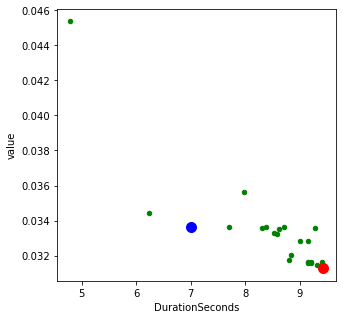

In [15]:
ax1 = imp19_study_df[imp19_study_df.DurationSeconds <= bestRun.DurationSeconds.max()].plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = bestRun.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimumRun.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

In [16]:
#lgb.plot_importance(bestModel, figsize=(10,10))

In [28]:
0.914985/(len(X_valid) * len(X_valid.columns)) * (5079**2 * len(X_valid.columns))/60

1.748717426840463

In [30]:
def getPredictionAndTime(model):
    start = datetime.now()
    prediction = np.rint(model.predict(X_valid, num_iteration=model.best_iteration))
    prediction = [np.argmax(x) for x in prediction]
    end = datetime.now()
    return prediction, end-start
    
bestTunerPrediction, bestTime = getPredictionAndTime(bestModel)
optimumTunerPrediction, optimumTime = getPredictionAndTime(optimumModel)

bestAccuracy = accuracy_score(Y_valid, bestTunerPrediction)
optimumAccuracy = accuracy_score(Y_valid, optimumTunerPrediction)
print(f"Best Accuracy: {bestAccuracy} in {bestTime}\nOptimum Accuracy: {optimumAccuracy} in {optimumTime}")

bestModelName = f"lightGBMBinary{k}_LGBMTunerBest_{tday}.sav"
optimumModelName = f"lightGBMBinary{k}_LGBMTunerOptimum_{tday}.sav"
bestModelPath = os.path.join(os.path.abspath("../notebooks/Models"), bestModelName)
optimumModelPath = os.path.join(os.path.abspath("../notebooks/Models"), optimumModelName)
pickle.dump(bestModel, open(bestModelPath, "wb"))
pickle.dump(optimumModel, open(optimumModelPath, "wb"))
print(f"Wrote best out model to {bestModelPath}\nWrote out optimum model to {optimumModelPath}")
%chime

Best Accuracy: 0.8884942455669306 in 0:00:01.578602
Optimum Accuracy: 0.8884942455669306 in 0:00:00.905001
Wrote best out model to M:\PAG2019\notebooks\Models\lightGBMBinaryBarren_LGBMTunerBest_20211130.sav
Wrote out optimum model to M:\PAG2019\notebooks\Models\lightGBMBinaryBarren_LGBMTunerOptimum_20211130.sav


In [23]:
len(X_valid), optimumTime.microseconds

(224957, 914985)

In [161]:
%%time
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X,y)

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\sklearn\model_selection\_split.py:440: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\sklearn\model_selection\_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.boo

Wall time: 25.2 s


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18580.942578149996, tolerance: 8.875296167711676
  model = cd_fast.enet_coordinate_descent(


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [187]:
imp_coeff.index.tolist(), relevant_features[1:20]

(['Sentinel2_B8A',
  'Sentinel2_B03',
  'MSAVI',
  'Sentinel2_B05',
  'DPR',
  'RGBNmean',
  'REDness',
  'RED',
  'GREEN',
  'GREENness',
  'BLUEness',
  'Sentinel2_B11',
  'NDPI',
  'NIRness',
  'BLUE',
  'NIR',
  'NDVI',
  'Sentinel2_B04',
  'Sentinel2_B08',
  'Sentinel2_B06'],
 Sentinel2_NDWI        0.347446
 NDVI                  0.329615
 Sentinel2_NDMI        0.328725
 GaussianSigma5_NIR    0.300532
 Sentinel2_B08         0.263607
 GaussianSigma2_NIR    0.261988
 DPR                   0.250857
 NIR                   0.248075
 Sentinel2_B07         0.244213
 Sentinel2_B8A         0.243112
 Sentinel2_BSI         0.240286
 Sentinel2_B06         0.236824
 NDPI                  0.214167
 GREENness             0.184640
 MSAVI                 0.182069
 NIR_LHE               0.174637
 Sentinel2_DBSI        0.166850
 RGBNmean              0.166844
 Sentinel2_B11         0.149992
 Name: LCClassInt, dtype: float64)

Best alpha using built-in LassoCV: 1.040277
Best score using built-in LassoCV: 0.361891
Lasso picked 20 variables and eliminated the other 22 variables


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Feature importance using Lasso Model')

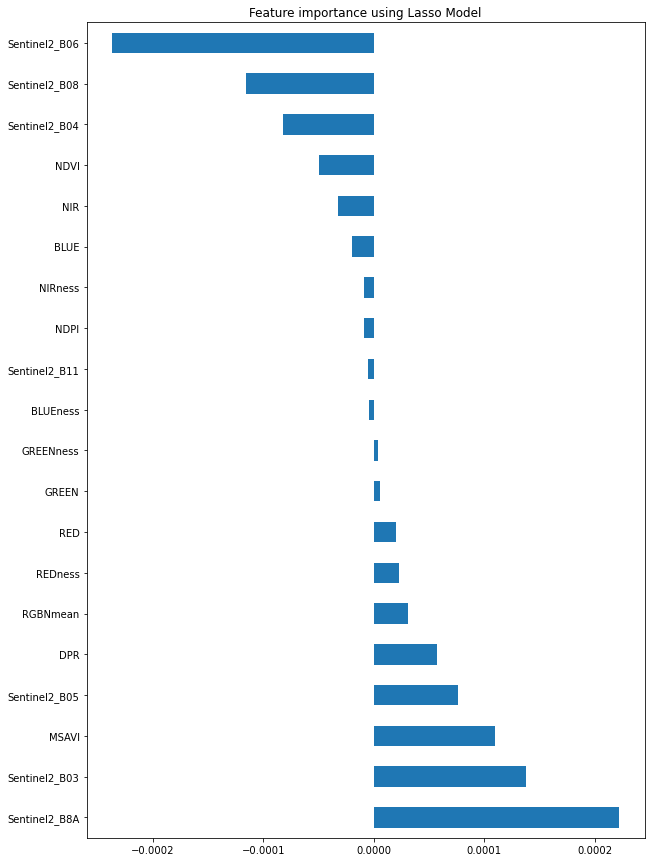

In [182]:
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % reg.score(X,y))
coef = pd.Series(reg.coef_, index=X.columns)
imp_coeff = coef[coef!=0]
print("Lasso picked " + str(sum(coef!=0)) + " variables and eliminated the other " + str(sum(coef==0)) + " variables")
imp_coeff.sort_values(ascending=False, inplace=True)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,15)
imp_coeff.plot(kind="barh")
plt.title("Feature importance using Lasso Model")

In [37]:
fullBinaryFiles = [os.path.abspath(f) for f in glob("../EPCExtent_30cm/Orthos_Segmented_Classifiedv3/*_TrainingStackV3_BinaryOptunaTunerGBLM.tif")]

with rio.open("../EPCExtent_30cm/Orthos_Segmented_Classifiedv3/W1004789_W449850_TrainingStackV3_BinaryOptunaTunerGBLM.tif") as src:
    bands = src.descriptions
    
for i, name in enumerate(bands):
    print(name)
    vrtopts = gdal.BuildVRTOptions(bandList=[i+1])
    vrtFile = f"C:/Users/BenJames/Downloads/FullBinaryClassification_{name}.vrt"
    if os.path.exists(vrtFile):
        continue
    t = gdal.BuildVRT(vrtFile, fullBinaryFiles, options=vrtopts)
    del t
%chime

Asphault
Barren
DenseVeg
Impervious
IrrigatedLand
PondLake
Pool
SparseVeg
Structure


In [30]:
# Pool at 0.88897777 with 20k or 50k sample size and lgbm tuner
# pool at 0.9992995555 with 50k sample size and optuna lgmb tuner

C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def useOptunaOptunaObjective(trainDataset, validDataset, lcClass):
    objectiveStudy = optuna.create_study(study_name=f"lightgbm_ObjectiveTuner_{k}", direction="minimize")

    model = olgb.train(
        params, train_set=trainDataset, valid_sets=[trainDataset, validDataset], verbose_eval=100,
        optuna_callbacks=[mlflow_callback], study=objectiveStudy
    )

    prediction = np.rint(model.predict(X_valid, num_iteration=model.best_iteration))
    accuracy = accuracy_score(Y_valid, prediction)

    best_params = model.params
    print(f"Best params for {k}:", best_params)
    print(f"  {k} Accuracy = {accuracy}")
    print("  Params: ")
    for key, value in best_params.items():
        print(f"    {key}: {value}")


    day = datetime.strftime(datetime.now(), "%Y%m%d")
    model_name = f"lightGBMBinary{k}_OptunaTuner_{day}.sav"
    model_path = os.path.join(os.path.abspath("../notebooks/Models"), model_name)
    pickle.dump(model, open(model_path, "wb"))
    params_path = f"../notebooks/Models/lightBinary{lcClass}Params_{day}.txt"
    with open(params_path, "w+") as txt:
        txt.write(json.dumps(params))
        print(f"Wrote out trained model for {k} to \n\t{model_path} and paramameters to \n\t{params_path}")
    end = datetime.now()
    print(f"Training took {end-start}\n")

    print(best_params)
    
    return objectiveStudy




Best trial:
	score 0.0010724698440817458
	took 2 minutes 22 seconds
	params {
          "lambda_l1": 0.006144408434141018,
          "lambda_l2": 3.5771466455438237
}
Optimum trial (#39): 
	score 0.0010951646608571258 
	took 1 minutes 18.5 seconds 
	params: {
          "feature_fraction": 0.88
}


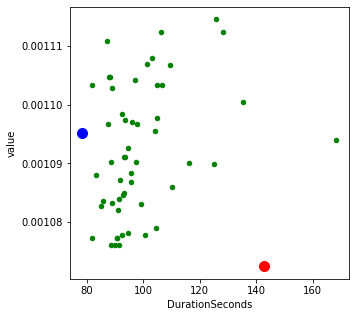

In [131]:
seconds_limit = 70
history = tunerStudy.trials_dataframe()
history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
#history.to_csv(f"./Models/lightGBMBinaryAsphaultStudy_{day}.csv", index=False)
best_params = tunerStudy.best_trial.params
best_score = tunerStudy.best_trial.value
print(f"Best trial:\n\tscore {best_score}\n\ttook {int(tunerStudy.best_trial.duration.seconds/60)} minutes {tunerStudy.best_trial.duration.seconds%60} seconds\n\tparams {json.dumps(best_params, indent=10)}")

best_performers = history[(history.value<(best_score*1.2))]# & (history.DurationSeconds < seconds_limit)]
highestAccuracy = history[history.value == history.value.min()]
highAccuracyLowRun = history[(history.DurationSeconds < highestAccuracy.DurationSeconds.max()*1.5) & (history.value < best_score / 0.95)]
optimum_trial = best_performers[best_performers.DurationSeconds == best_performers.DurationSeconds.min()] 
optimum_trial_number = optimum_trial.number.values[0]
optimum_score = optimum_trial.value.values[0]
optimum_time = optimum_trial.DurationSeconds.values[0]
optimum_params = tunerStudy.get_trials()[optimum_trial_number].params
print(f"Optimum trial (#{optimum_trial_number}): \n\tscore {optimum_score} \n\ttook {int(optimum_time/60)} minutes {round(optimum_time%60,1)} seconds \n\tparams: {json.dumps(optimum_params, indent=10)}")

ax1 = highAccuracyLowRun.plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = highestAccuracy.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimum_trial.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

Best trial:
	score 0.0007565977694676177
	took 1 minutes 31 seconds
	params {
          "lambda_l1": 0.028664020826938516,
          "lambda_l2": 1.3198683384921155e-08
}
Optimum trial (#20): 
	score 0.000775853596216345 
	took 1 minutes 4.0 seconds 
	params: {
          "num_leaves": 124
}


C:\Users\BenJames\anaconda3\envs\geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


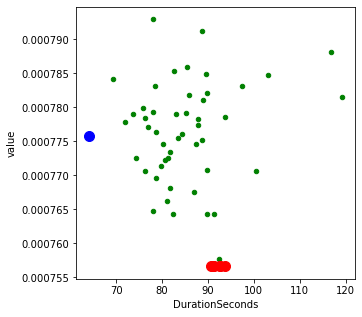

In [49]:
seconds_limit = 70
history = study.trials_dataframe()
history["DurationSeconds"] = history.duration.apply(lambda d: d/np.timedelta64(1, 's'))
history.to_csv(f"./Models/lightGBMBinaryAsphaultStudy_{day}.csv", index=False)
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f"Best trial:\n\tscore {best_score}\n\ttook {int(study.best_trial.duration.seconds/60)} minutes {study.best_trial.duration.seconds%60} seconds\n\tparams {json.dumps(best_params, indent=10)}")

best_performers = history[(history.value<(best_score*1.2))]# & (history.DurationSeconds < seconds_limit)]
highestAccuracy = history[history.value == history.value.min()]
highAccuracyLowRun = history[(history.DurationSeconds < highestAccuracy.DurationSeconds.max()*1.5) & (history.value < best_score / 0.95)]
optimum_trial = best_performers[best_performers.DurationSeconds == best_performers.DurationSeconds.min()] 
optimum_trial_number = optimum_trial.number.values[0]
optimum_score = optimum_trial.value.values[0]
optimum_time = optimum_trial.DurationSeconds.values[0]
optimum_params = study.get_trials()[optimum_trial_number].params
print(f"Optimum trial (#{optimum_trial_number}): \n\tscore {optimum_score} \n\ttook {int(optimum_time/60)} minutes {round(optimum_time%60,1)} seconds \n\tparams: {json.dumps(optimum_params, indent=10)}")

ax1 = highAccuracyLowRun.plot(kind='scatter', x='DurationSeconds', y='value', color='green', s=20, figsize=(5,5))    
ax2 = highestAccuracy.plot(kind='scatter', x='DurationSeconds', y='value', color='red', s=100, ax=ax1)
ax3 = optimum_trial.plot(kind='scatter', x='DurationSeconds', y='value', color='blue', s=100, ax=ax1)

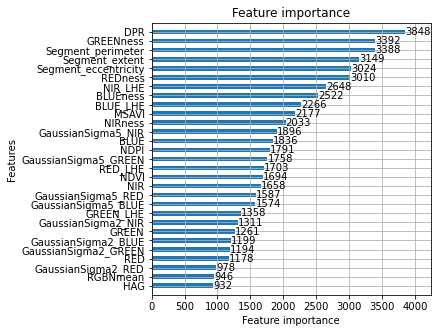

In [99]:
olgb.plot_importance(model, height=0.5, figsize=(5,5))

In [30]:
finished()

In [46]:
from skimage.morphology import binary_closing, binary_opening, square, remove_small_holes, disk, square, remove_small_objects



def removeClassSmaller(array, class_num, min_size):
    non = np.where(array==class_num, 255, array)
    removed = remove_small_objects(array==class_num, min_size=min_size, connectivity=1)
    array_rem = np.where(removed==0, non, array)
    return array_rem



In [47]:
with rio.open("../EPCExtent_30cm\Orthos_Segmented_Classifiedv3\W989789_W439850_TrainingStackV3_AsphaultBinaryLGBNewishGBLM.tif") as src:
    asphault = src.read(1)
    kwargs = src.profile

with rio.open("C:/Users/BenJames/Downloads/testAsphault.tif", "w", **kwargs) as dst:
    dst.write(cleanupAsphault(asphault).astype(np.uint8), 1)

